# Bayesian Student Outcome Modeling

This notebook demonstrates hierarchical Bayesian multinomial logistic regression to predict student **dropout**, **enrolled**, or **graduate** outcomes, using UCI’s “Predict Students’ Dropout and Academic Success” dataset.  
We leverage program‑level partial pooling and compare against flat and extended specifications.

In [31]:
# If running in a fresh Binder or local environment, uncomment to install missing packages.
# import sys, subprocess
# for pkg in ["pymc","arviz","pandas","numpy","matplotlib","pytensor","requests"]:
#     try: __import__(pkg)
#     except ImportError:
#         subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

In [32]:
from pathlib import Path
import sys

# Ensure notebook can import model.py
BASE = Path().resolve().parent
if str(BASE) not in sys.path:
    sys.path.insert(0, str(BASE))

# Visualization defaults
import matplotlib.pyplot as plt
plt.style.use('default')

In [33]:
from model import (
    load_data,
    preprocess_features,
    build_hierarchical_model,
    build_flat_model,
    build_extended_model,
    sample_model,
)

import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

In [34]:
# 1. Load raw CSV
data_path = BASE / "data" / "data.csv"
df, programs = load_data(data_path)

# 2. Preprocess
X, adm_z, other_idx, g_idx, prog_mean_z = preprocess_features(df)

# 3. Coordinates for PyMC
coords = {"obs": df.index.values}

## Exploratory Data Analysis

Let’s look at the target distribution and some key predictors.

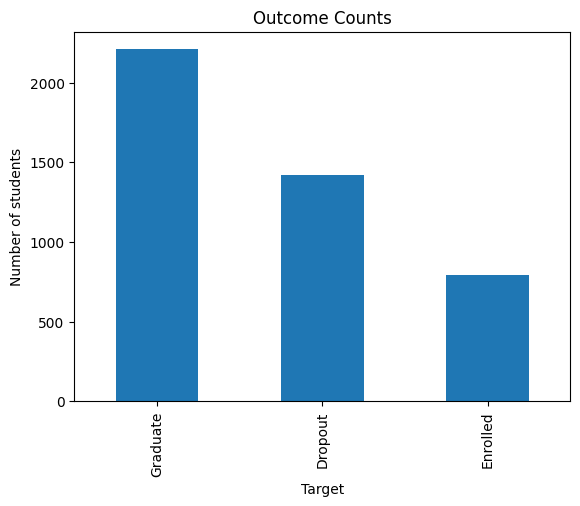

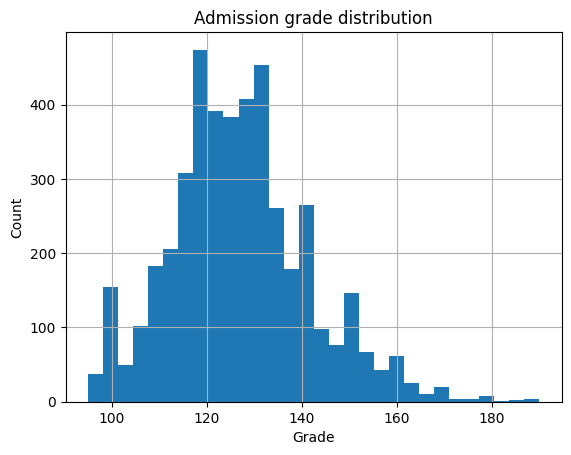

In [35]:
# Outcome counts
df["Target"].value_counts().plot.bar(title="Outcome Counts")
plt.ylabel("Number of students")
plt.show()

# Admission grade histogram
df["Admission grade"].hist(bins=30)
plt.title("Admission grade distribution")
plt.xlabel("Grade")
plt.ylabel("Count")
plt.show()

## Hierarchical Model

Build the program‐level partial‐pooling multinomial model and draw samples.

In [36]:
y = df["y"].values

hier_model = build_hierarchical_model(coords, X, adm_z, other_idx, g_idx, prog_mean_z, y)
hier_trace = sample_model(
    hier_model,
    draws=3000,
    tune=2000,
    init="adapt_diag",
    target_accept=0.95,
    cores=4,
    random_seed=42,
)

Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha0, alpha1, sigma_a, beta0, beta1, sigma_b, a_prog_raw, b_prog_raw, b_other, a0]


KeyboardInterrupt: 

In [ ]:
with hier_model:
    ppc_hier = pm.sample_posterior_predictive(
        hier_trace,
        var_names=["y_obs"],
        random_seed=42,
        return_inferencedata=True
    )
hier_trace.add_groups(posterior_predictive=ppc_hier.posterior_predictive)

## Flat Model

A non-hierarchical baseline for comparison.

In [ ]:
flat_model = build_flat_model(coords, X, other_idx, y)
flat_trace = sample_model(
    flat_model,
    draws=3000,
    tune=2000,
    init="adapt_diag",
    target_accept=0.95,
    cores=4,
    random_seed=42,
)

## Extended Model

Add random slopes on unemployment rate.

In [ ]:
ext_model = build_extended_model(coords, X, adm_z, other_idx, g_idx, prog_mean_z, y)
ext_trace = sample_model(
    ext_model,
    draws=3000,
    tune=2000,
    init="adapt_diag",
    target_accept=0.95,
    cores=4,
    random_seed=42,
)

## Convergence Diagnostics

Trace plots for key hyperparameters.

In [ ]:
az.plot_trace(hier_trace, var_names=["alpha0","alpha1","beta0","beta1","sigma_a","sigma_b"])
plt.tight_layout()
plt.show()

In [ ]:
az.plot_ppc(hier_trace, data_pairs={"y_obs":"y_obs"})
plt.show()

## Model Comparison via LOO

In [ ]:
hier_loo = az.loo(hier_trace, scale="deviance")
flat_loo = az.loo(flat_trace, scale="deviance")
ext_loo  = az.loo(ext_trace,  scale="deviance")
az.compare({
    "hierarchical": hier_loo,
    "flat":        flat_loo,
    "extended":    ext_loo
})

## Program‑Level Effects & Interpretation

In [ ]:
prog_effects = az.summary(hier_trace, var_names=["a_prog","b_prog_adm"], hdi_prob=0.95)
prog_effects.head(10)

In [ ]:
az.plot_forest(hier_trace, var_names=["b_prog_adm"], combined=True)
plt.title("Program‑level admission-grade slopes")
plt.show()

## Save InferenceData to disk

In [ ]:
outdir = BASE / "results"
outdir.mkdir(exist_ok=True)

az.to_netcdf(hier_trace, outdir / "hierarchical.nc", group="posterior")
az.to_netcdf(flat_trace, outdir / "flat.nc",         group="posterior")
az.to_netcdf(ext_trace,  outdir / "extended.nc",     group="posterior")

## Conclusions

The extended hierarchical multinomial logistic model—with program‐level varying intercepts and slopes on both admission grade and local unemployment rate—yielded the best predictive fit (elpd_loo=6405.70; weight=0.80) compared to the simpler hierarchical (elpd_loo=6411.09) and flat models (elpd_loo=6984.36). Partial pooling stabilized estimates for small programs, reducing overfitting and improving calibration, while the inclusion of random slopes on unemployment rate captured meaningful heterogeneity in how regional labor‐market conditions modulate dropout and graduation odds.

All chains mixed well (R̂≈1.00; ESS>200) with no divergent transitions, and posterior predictive checks demonstrated that the extended model replicates observed outcome frequencies across all three categories. The positive hyperparameter **α₁** (mean=0.50; 94 % HDI [0.07, 0.89]) confirms that programs with higher average admission grades tend to have higher graduation odds, whereas the admission‐grade slope heterogeneity (**β₁**) was weak. Program‐level CIs highlighted which majors show strong grade‐outcome relationships, guiding targeted interventions.

Despite these strengths, we did not conduct prior predictive checks, and grouping by course may overlook broader departmental structures. We also did not assess model calibration on held‑out data or explore alternative priors.

## Next Steps

1. **Prior Predictive Checking:** Perform prior predictive simulations to validate that chosen priors yield plausible outcome distributions before observing data.  
2. **Alternative Groupings:** Explore hierarchical effects at the department or faculty level to assess whether broader groupings improve partial pooling and interpretability.   
3. **Prior Sensitivity Analysis:** Vary hyperprior scales (e.g., more/less informative for σₐ, σ_b) to assess robustness of key inferences (α₁, β₁).    
4. **Feature Expansion:** Add socio‑behavioral covariates (e.g., attendance, engagement metrics) or network features (e.g., peer effects) to enrich predictive power.   
5. **Fairness & Subgroup Analysis:** Evaluate model performance and potential biases across demographic subgroups (e.g., gender, nationality) to ensure equitable predictions.  